In [142]:
from qgis.core import QgsVectorLayer,QgsField,edit
from qgis.PyQt.QtCore import QVariant
from paras_2 import decay_tree_potential,NP_retention
import numpy as np
#for developing
import geopandas as gpd
import matplotlib.pyplot as plt

<AxesSubplot:>

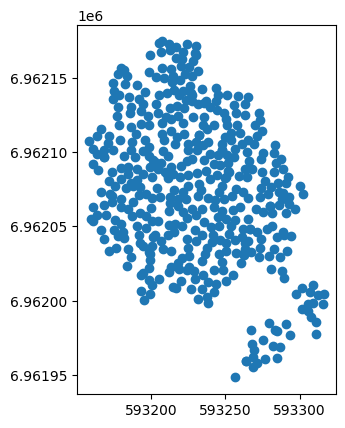

In [2]:
#example cutting area
data_example = "data_example\ReTreeT.gpkg"
layer = "treemap"
data_qgis = QgsVectorLayer(data_example+"|layername="+layer,"treemap","ogr")
data_df = gpd.read_file(data_example,layer = layer)

data_df

data_df.plot()

In [3]:
data_df

,CHM,SPECIALFEATURECODE,SPECIALFEATUREADDITIONALCODE,FERTILITYCLASS,DEVELOPMENTCLASS,STEMCOUNTPINE,STEMCOUNTDECIDUOUS,STEMCOUNTSPRUCE,MEANDIAMETERDECIDUOUS,MEANDIAMETERPINE,...,PaajakoNro,Nimi,Nimi_2,leimikko,DTW_1,euc_1,DTW_1n,biod,biodn,geometry
0,97,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.068761,52.0,0.010111,0.000000,0.000000,POINT (593161.000 6962063.000)
1,81,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.047743,44.0,0.007020,0.000000,0.000000,POINT (593161.000 6962053.500)
2,81,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.060228,46.0,0.008856,0.000000,0.000000,POINT (593159.500 6962055.000)
3,97,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.049569,48.0,0.007289,0.000000,0.000000,POINT (593163.500 6962057.500)
4,144,None,None,4,03,1168.0,NaN,10.0,NaN,16.59,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.055280,45.0,0.008129,0.018579,0.025352,POINT (593179.857 6962051.500)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,169,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.506014,106.0,0.074406,0.337514,0.460561,POINT (593235.500 6962094.500)
441,218,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.343525,100.0,0.050513,0.337514,0.460561,POINT (593236.833 6962087.389)
442,227,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.310039,98.0,0.045589,0.337514,0.460561,POINT (593239.389 6962082.167)
443,220,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.385177,103.0,0.056638,0.337514,0.460561,POINT (593244.375 6962084.625)


In [50]:
def limit(x,minimum,maximum):
    fc = lambda x : x if x>minimum and x<maximum else (minimum if x<=minimum else maximum)
    
    return fc(x)

In [76]:
def normalizeValue(in_feat:QgsVectorLayer,fieldname:str,filtervalues:tuple,transpose:bool=False):
    """
    This normalize values between 0 and 1 by formula f(x) = x-min(x) / max(x) - min(x)
    You can limit values between specific values and transpose the values
    """
    in_feat.dataProvider().addAttributes([QgsField(fieldname+"n",QVariant.Double)])
    in_feat.updateFields()
    
    lis = [feat[fieldname] for feat in in_feat.getFeatures() if feat[fieldname] is not None]
    
    #print (lis)
    if filtervalues is not None:
        lis = [limit(i,filtervalues[0],filtervalues[1]) for i in lis]
        with edit(in_feat):
            for feat in in_feat.getFeatures():
                feat[fieldname]=limit(feat[fieldname],filtervalues[0],filtervalues[1])
                in_feat.updateFeature(feat)
                
    try:
        minlis = min(list(lis))
        maxlis = max(list(lis))
        
    except:
        minlis = 0
        maxlis = 1
    
    
    with edit(in_feat):
        for feat in in_feat.getFeatures():
            if feat[fieldname] is not None:
                if transpose == False:
                    feat[fieldname+"n"] = (feat[fieldname]-minlis) / (maxlis-minlis)
                else:
                    feat[fieldname+"n"] = 1- ((feat[fieldname]-minlis) / (maxlis-minlis))
            else:
                feat[fieldname+"n"] = 0.0
            
            in_feat.updateFeature(feat)


Filtering between 0.0 and 0.8
min ja max finded: 0.0,0.8
        DTW_1    DTW_1n
0    0.068761  0.914048
1    0.047743  0.940321
2    0.060228  0.924714
3    0.049569  0.938038
4    0.055280  0.930900
..        ...       ...
440  0.506014  0.367483
441  0.343525  0.570593
442  0.310039  0.612452
443  0.385177  0.518528
444  0.421289  0.473389

[445 rows x 2 columns]


(array([ 57.,   4.,  25.,  27.,  35.,  29.,  28.,  42., 102.,  96.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

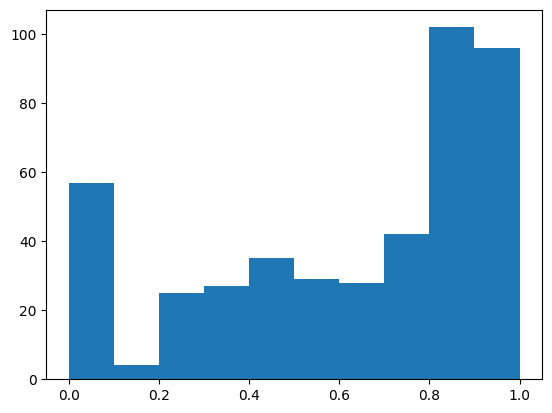

In [80]:
#we test about normalization of DTW value
normalizeValue(data_qgis,"DTW_1",(0.0,0.8),True)

data_df = gpd.read_file(data_example,layer = layer)
t = data_df[['DTW_1','DTW_1n']]#where(data_df['DTW_1n']<0,inplace=True)

print (t)

plt.hist(data_df["DTW_1n"])

In [92]:
def simpson_di(species):
    """
    This calculates simpson diversity index by formula D = n(n-1)/N(N-1)
    Species list are form of [10,1,3,4]
    """
    
    proportions = [i/sum(species) for i in species]
    simpsons_index = 0
    for proportion in proportions:
        simpsons_index += proportion ** 2
    
    return (1 - simpsons_index) / (1-1/len(species)) if simpsons_index > 0 and len(species)>1 else 0


In [86]:
def calculateBiodiversity(in_feat:QgsVectorLayer,speciesfield:list):
    
    in_feat.dataProvider().addAttributes([QgsField("biod",QVariant.Double)])
    in_feat.updateFields()
    
    with edit(in_feat):
        for feat in in_feat.getFeatures():
            
            sim_di = simpson_di([feat[i] for i in speciesfield if feat[i] > 0])
            if feat['SPECIALFEATURECODE'] is not None:
                conver_cof = sim_di * 0.1
            else:
                conver_cof = 0
            
            feat['biod'] = float(sim_di+conver_cof)
            in_feat.updateFeature(feat)
    
    normalizeValue(in_feat,'biod',None,False)

In [93]:
calculateBiodiversity(data_qgis,["STEMCOUNTPINE","STEMCOUNTDECIDUOUS","STEMCOUNTSPRUCE"])


data_df = gpd.read_file(data_example,layer = layer)
data_df

min ja max finded: 0.0,1.0880067706477343


,CHM,SPECIALFEATURECODE,SPECIALFEATUREADDITIONALCODE,FERTILITYCLASS,DEVELOPMENTCLASS,STEMCOUNTPINE,STEMCOUNTDECIDUOUS,STEMCOUNTSPRUCE,MEANDIAMETERDECIDUOUS,MEANDIAMETERPINE,...,PaajakoNro,Nimi,Nimi_2,leimikko,DTW_1,euc_1,DTW_1n,biod,biodn,geometry
0,97,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.068761,52.0,0.914048,0.000000,0.000000,POINT (593161.000 6962063.000)
1,81,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.047743,44.0,0.940321,0.000000,0.000000,POINT (593161.000 6962053.500)
2,81,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.060228,46.0,0.924714,0.000000,0.000000,POINT (593159.500 6962055.000)
3,97,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.049569,48.0,0.938038,0.000000,0.000000,POINT (593163.500 6962057.500)
4,144,None,None,4,03,1168.0,NaN,10.0,NaN,16.59,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.055280,45.0,0.930900,0.037034,0.034039,POINT (593179.857 6962051.500)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,169,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.506014,106.0,0.367483,0.502895,0.462217,POINT (593235.500 6962094.500)
441,218,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.343525,100.0,0.570593,0.502895,0.462217,POINT (593236.833 6962087.389)
442,227,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.310039,98.0,0.612452,0.502895,0.462217,POINT (593239.389 6962082.167)
443,220,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.385177,103.0,0.518528,0.502895,0.462217,POINT (593244.375 6962084.625)


(array([70., 39., 79., 72., 39., 22., 22., 43., 33., 26.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

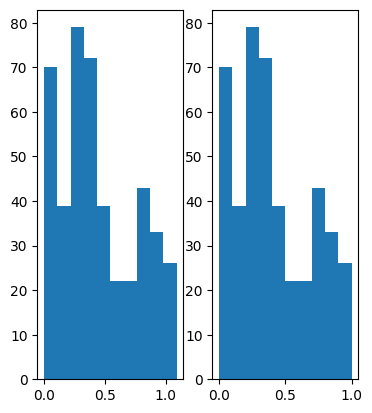

In [94]:
plt.subplot(1,3,1)
plt.hist(data_df["biod"])

plt.subplot(1,3,2)
plt.hist(data_df["biodn"])

In [133]:
def calculateDecayTreePotential(in_feat):
    
    in_feat.dataProvider().addAttributes([QgsField("dtree",QVariant.Double)])
    in_feat.updateFields()
    
    #treelist = [1,2,29]
    puuH = [("MEANHEIGHTPINE",1),("MEANHEIGHTSPRUCE",2),("MEANHEIGHTDECIDUOUS",29)]
    fc_d = lambda t : t.replace("HEIGHT","DIAMETER")
    fc_v = lambda t : t.replace("HEIGHT","VOLUME")
    
    with edit(in_feat):
        for feat in in_feat.getFeatures():
            #maxH = [feat["MEANHEIGHTPINE"],feat["MEANHEIGHTSPRUCE"],feat["MEANHEIGHTDECIDUOUS"]]
            #maxItem = max(maxH)
            #maxH = puuH[str(maxH.index(maxItem))]
            dcp = decay_tree_potential('zone'+str(feat['PaajakoNro']))

            if feat['FERTILITYCLASS'] > 0 and max([feat[p[0]] for p in puuH]) >0:
                if feat['FERTILITYCLASS']>6:
                    para = [dcp[6][i[1]] for i in puuH]
                else:
                    para = [dcp[int(feat['FERTILITYCLASS'])][i[1]] for i in puuH]
                                    
                #d = [maxH[i].replace("HEIGHT","DIAMETER") i for 
                potvalues = [limit(np.poly1d(para[i])(feat[fc_d(p[0])]),0,2) for i,p in enumerate(puuH) if feat[fc_d(p[0])] > 0]
                #potvalues = sum([potvalues[i]*feat[fc_v(p[0])] for i,p in enumerate(puuH)])
            else:
                potvalues=[0]
            
            feat["dtree"]=float(sum(potvalues))
            
            
            in_feat.updateFeature(feat)
    
    normalizeValue(in_feat,"dtree",None,False)
    #normalizeValue(in_feat,"DTW_1")

min ja max finded: 0.0,2.5978995214780864
0      0.050933
1      0.050933
2      0.050933
3      0.050933
4      0.106961
         ...   
440    0.415784
441    0.415784
442    0.415784
443    0.415784
444    0.415784
Name: dtreen, Length: 445, dtype: float64


(array([ 18.,  43., 142.,  45.,  28.,  28.,   1.,   7.,  10., 123.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

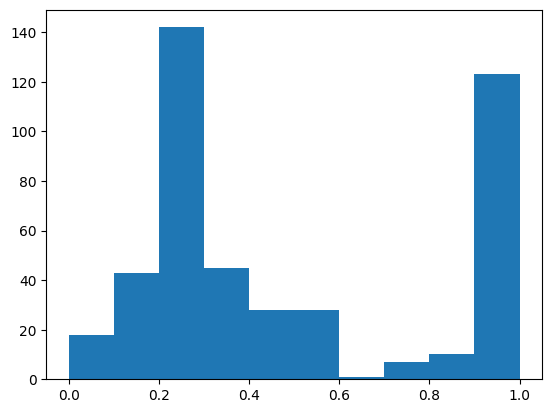

In [134]:
calculateDecayTreePotential(data_qgis)

data_df = gpd.read_file(data_example,layer = layer)

print(data_df['dtreen'])

plt.hist(data_df['dtreen'])

In [151]:
def calculateNPretention(in_feat):
    in_feat.dataProvider().addAttributes([QgsField("pRetent",QVariant.Double)])
    in_feat.updateFields()
    ret = NP_retention()
    with edit(in_feat):
        for feat in in_feat.getFeatures():
            if type(feat['euc_1']) in (float,int):
                feat['pRetent'] = ret['P']/limit(feat['euc_1'],0,40) * feat['DTW_1n']
                
            in_feat.updateFeature(feat)
    
    normalizeValue(in_feat,'pRetent',None,False)


min ja max finded: 0.0,1.5421647973652928
     pRetentn   pRetent  euc_1
0    0.283594  0.437349   52.0
1    0.291746  0.449920   44.0
2    0.286904  0.442453   46.0
3    0.291038  0.448828   48.0
4    0.288823  0.445412   45.0
..        ...       ...    ...
440  0.114016  0.175831  106.0
441  0.177033  0.273015  100.0
442  0.190020  0.293043   98.0
443  0.160880  0.248103  103.0
444  0.146875  0.226505  109.0

[445 rows x 3 columns]


(array([ 89., 102., 202.,  40.,   6.,   4.,   0.,   0.,   0.,   2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

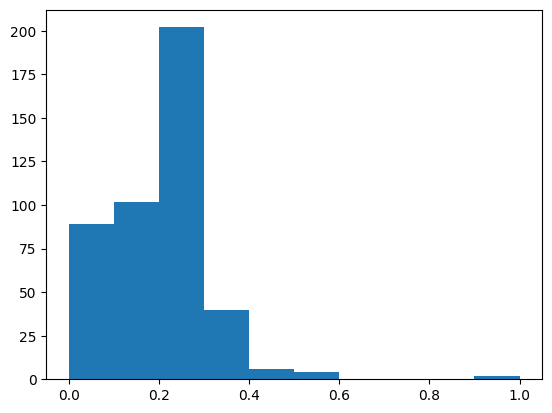

In [152]:
calculateNPretention(data_qgis)

data_df = gpd.read_file(data_example,layer = layer)

print(data_df[['pRetentn','pRetent','euc_1']])

plt.hist(data_df['pRetentn'])

In [153]:
def calculateEnvValue(in_feat,weights):
    in_feat.dataProvider().addAttributes([QgsField("env_value",QVariant.Double)])
    in_feat.updateFields()

    with edit(in_feat):
        for feat in in_feat.getFeatures():
            feat['env_value'] = feat['biodn']*weights['BIO']+feat['pRetentn']*weights['NP']+feat['DTW_1n']*weights['DTW']+feat['dtreen']*weights['LP']
    
            in_feat.updateFeature(feat)